# Unit 05

`````{tab-set}
````{tab-item} Objective

::::{important} Objective

The goal of this practical course is to generate a database for a set of molecules including structural features (structural representations and descriptors) as well as experimental features (absorption adn emission specvtra). 📈 
To this end, we will work with the data of 19 cyanine dyes, as obtained from [PhotochemCAD](https://www.photochemcad.com/).

In the folder ```data``` you will find subfolders with the following name and information:

- ```absorption```: UVvis absorption spectra
- ```emission```: emission spectra
- ```xyz_files```: cartesian coordinates

In each of these folders, you find individual files, whereas the filenames contain information on the data type (e.g. start with 'abs' or 'em' for absorption and emission data) and the ID of the molecule. The respective IDs range from **K01** to **K19**.

Upon construction of the database, the Tanimoto similarity for all unique pairs in the database is to be computed and visualized in form of a graph (network).

:::{admonition} Extracting IDs from the filenames
:class: dropdown
The filenames follow all the same concept, one example is for instance 'abs_K09.txt'

With `filename[:-4].split('_')[-1]`, which gives **{eval}`str('abs_K09.txt')[:-4].split('_')[-1]`**, we can acces the IDs of the respective molecules.
:::

::::

````


````{tab-item} Further Information

:::{admonition}Further Information
- [`rdkit` package](https://www.rdkit.org/docs/source/rdkit.html)
- [`rdkit.Chem` package](https://www.rdkit.org/docs/source/rdkit.Chem.html)
- [`networkx` tutorial](https://networkx.org/documentation/stable/tutorial.html)
:::

````
`````


In [71]:
import os, sys

import pandas as pd
import numpy as np

import py3Dmol
import rdkit
from rdkit.Chem import AllChem
from rdkit.Chem import rdDetermineBonds

import digichem

## C) Database of Cyanines with structural and experimental features

::::{tip} Task C1

Generate a dictionary `d_cyanines` for the 19 given cyanine dyes including structural and experimental features, i.e., absorption and emission spectra as obtained from [PhotochemCAD](https://www.photochemcad.com/). 📈 

In the folder ```data``` you will find subfolders with the following name and information:

- ```absorption```: UVvis absorption spectra
- ```emission```: emission spectra
- ```xyz_files```: cartesian coordinates

In each of these folders, you find individual files, whereas the filenames contain information on the data type (e.g. start with 'abs' or 'em' for absorption and emission data) and the ID of the molecule. The respective IDs range from **K01** to **K19**.

Generate a dictionary `d_cyanines` with the IDs of the molecules as **keys** and dictionaries of structural and experimental features as **values**.
The experimental features should have the following keys and types:

ABSORPTION SPECTRUM ('abs_spec')
:  absorption spectrum (dtype: numpy.ndarray) with wavelengths in the first column (e.g., `d_cyanines['K01']['abs_spec'][0:,0]`) and intensities in the second column (e.g., `d_cyanines['K01']['abs_spec'][0:,1]`)

EMISSION SPECTRUM ('em_spec')
:  emission spectrum (dtype: numpy.ndarray) with wavelengths in the first column (e.g., `d_cyanines['K01']['em_spec'][0:,0]`) and intensities in the second column (e.g., `d_cyanines['K01']['em_spec'][0:,1]`)


:::{admonition} Extracting IDs from the filenames
:class: dropdown
The filenames follow all the same concept, one example is for instance 'abs_K09.txt'

With `filename[:-4].split('_')[-1]`, which gives **{eval}`str('abs_K09.txt')[:-4].split('_')[-1]`**, we can acces the IDs of the respective molecules.
:::

:::{admonition} Structural representations and descriptors
:class: dropdown
You can use the functions from **unit 02** to generate a dictionary of structural representations and descriptors for the individual molecules. You can eitehr use your own functions to access the properties or use the function `__xyz2dict__` from the `digichem` module to generate the dictionary of the structural properties.
You can call this function in the following way:

```{code-block} python
:lineno-start: 1
:emphasize-lines: 3

import digichem
xyz_path = os.path.join(os.getcwd(), 'data', 'xyz_files')
d_struc = digichem.__xyz2dict__(xyz_path=xyz_path)
```
:::

:::{admonition} List of filenames to be read
:class: dropdown
 To make sure, one only reads the files that store emission or absorption data, you can include a condition, when generating the list of filenames to be read. 
 This can be realized in python using for instance the following code to add only those filenames to the list that start with 'abs'.

```{code-block} python
:lineno-start: 4
:emphasize-lines: 6
import os

abs_files = sorted([f for f in os.listdir(spec_path) if f.startswith('abs')])
```
:::

:::{admonition} Reading experimental files
:class: dropdown
To read the experimental data, you can use the pandas library with its function `pandas.read_csv()`. 
Herein, the experimental data is seperated by tabs (```'\t'```) and the header occupies only the first line.
The following example demonstrates how to read one experimental file, skip the first row and gives the columns the names 'nm' and 'int', since the first column are the wavelengths and the second the respective intensitties.

```{code-block} python
:lineno-start: 7
:emphasize-lines: 7, 10
import pandas as pd

spec_file = os.path.join(os.getcwd(), 'data', 'absorption', 'abs_K01.txt')
df = pd.read_csv(spec_file, sep='\t', header=0, skiprows=0, names=['nm', 'int'])
```
:::

When combining the dictionaries containing structural and experimental data, it's crucial to be mindful, especially considering that the experimental data may be incomplete. For instance, certain absorption or emission spectra might be absent. 
Ensure that you include **NoneType** values for the corresponding dyes in cases where experimental data is missing.

::::

In [72]:
# read structural data, generate representations/descriptors

d_struc = digichem.__xyz2dict__(
    xyz_path=os.path.join(os.getcwd(), 'data', 'xyz_files'),
    extension='xyz'
)

[12:01:50] WARNING: Proton(s) added/removed

[12:01:50] WARNING: Proton(s) added/removed



In [73]:
# read experimental spectra
import pandas as pd
import numpy as np

# Initialize dictionary for experimental data
d_exp = {}

# Get molecule IDs from structural data
mol_ids = sorted(d_struc.keys())

for mol_id in mol_ids:
    d_exp[mol_id] = {}
    
    # Read absorption spectrum
    abs_file = os.path.join(os.getcwd(), 'data', 'absorption', f'abs_{mol_id}.txt')
    if os.path.exists(abs_file):
        df_abs = pd.read_csv(abs_file, sep='\t', header=0, names=['nm', 'int'])
        d_exp[mol_id]['abs_spec'] = df_abs.to_numpy()
    else:
        d_exp[mol_id]['abs_spec'] = None
    
    # Read emission spectrum
    em_file = os.path.join(os.getcwd(), 'data', 'emission', f'em_{mol_id}.txt')
    if os.path.exists(em_file):
        df_em = pd.read_csv(em_file, sep='\t', header=0, names=['nm', 'int'])
        d_exp[mol_id]['em_spec'] = df_em.to_numpy()
    else:
        d_exp[mol_id]['em_spec'] = None

print(f"Loaded experimental data for {len(d_exp)} molecules")

Loaded experimental data for 19 molecules


In [74]:
# merge dictionaries of structures and spectra into d_cyanines

d_cyanines = {}

for mol_id in d_struc.keys():
    d_cyanines[mol_id] = {**d_struc[mol_id], **d_exp[mol_id]}

::::{tip} Task C2

Find the absorption and emission maxima ($\lambda_{max}^{abs}$ and $\lambda_{max}^{em}$) from the arrays stored under the keys `'abs_spec'` and `'em_spec'` in `d_cyanines`. 📈 Add the respective values for every dye molecule into the _cyanines`dictionary with the following keys:

ABSORPTION MAXIMUM ('abs_max')
:  absorption maximum (dtype: float), i.e., the wavelength where the highest absorption intensity is observed

EMISSION MAXIMUM ('em_max')
:  emission maximum (dtype: float), i.e., the wavelength where the highest emission intensity is observed


:::{admonition} Index of a maximum value in an array
:class: dropdown
The following code first finds the index of the maximum value in the second column of the given array using np.argmax, then extracts the corresponding value from the first column.

```{code-block} python
:lineno-start: 1
:emphasize-lines: 10, 11
import numpy as np
# sample data
data = np.array([[220.0, 28742.0],
                 [220.25, 29013.0],
                 [220.5, 29485.0],
                 [699.5, 83.18],
                 [699.75, 88.894],
                 [700.0, 126.67]])
                 
max_index = np.argmax(data[:, 1])
nm_max = data[max_index,0]
```
:::

**For which feature do we have values for every dye? 'abs_max' or 'em_max'?**

::::

In [75]:
# extract absorption and emission maxima and add these integers to d_cyanines

for mol_id in d_cyanines.keys():
    
    # Extract absorption maximum
    if d_cyanines[mol_id]['abs_spec'] is not None:
        abs_data = d_cyanines[mol_id]['abs_spec']
        max_index = np.argmax(abs_data[:, 1])  # Find max intensity index
        d_cyanines[mol_id]['abs_max'] = float(abs_data[max_index, 0])  # Get wavelength
    else:
        d_cyanines[mol_id]['abs_max'] = None
    
    # Extract emission maximum
    if d_cyanines[mol_id]['em_spec'] is not None:
        em_data = d_cyanines[mol_id]['em_spec']
        max_index = np.argmax(em_data[:, 1])  # Find max intensity index
        d_cyanines[mol_id]['em_max'] = float(em_data[max_index, 0])  
    else:
        d_cyanines[mol_id]['em_max'] = None

# Verify
print("Sample maxima for K01:")
print(f"  Absorption max: {d_cyanines['K01']['abs_max']} nm")
print(f"  Emission max: {d_cyanines['K01']['em_max']} nm")

Sample maxima for K01:
  Absorption max: 524.25 nm
  Emission max: None nm


::::{tip} Task C3

Compute the tanimoto similarities between all pairs of the 19 cyanine dyes.
Visualize the molecules that are similar in a network, where the nodes are colored based on the value absorption maximum.

For this, you can follow the procedure instructions form this study: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-022-00664-x (Visualizing chemical space networks with RDKit and NetworkX)


:::{admonition} networkx
:class: dropdown
The following code gives an example how to work with networkx

```{code-block} networkx example
:lineno-start: 1
:emphasize-lines: 1
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Add nodes
G.add_node(1)
G.add_nodes_from([2, 3, 4])

# Add edges
G.add_edge(1, 2)
G.add_edges_from([(1, 3), (2, 4)])

# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')

# Show the plot
plt.show()
```
:::

:::{admonition} Node colors by absorption maximum
:class: dropdown
The following code can be used to access a color map for the graph plots, assigning the nodes depending on the absorption maximum of the respective molecule a different color: 

```{code-block} networkx example
:lineno-start: 1
:emphasize-lines: 1
from matplotlib import colors

color_map = []
for node in G1.nodes(data=True):
    if 850 >= node[1]["abs_max"] > 800.0:
        color_map.append("darkred")
    elif 800 >= node[1]['abs_max'] > 750.0:
        color_map.append('red')
    elif 750 >= node[1]['abs_max'] > 700.0:
        color_map.append('orange')
    elif 700 >= node[1]['abs_max'] > 650.0:
        color_map.append('yellow')
    elif 650 >= node[1]['abs_max'] > 600.0:
        color_map.append('green')
    elif 600 >= node[1]['abs_max'] > 550.0:
        color_map.append('lightblue')
    elif 550 >= node[1]['abs_max'] > 500.0:
        color_map.append('blue')
    elif 500 >= node[1]['abs_max'] > 450.0:
        color_map.append('purple')
    else:
        color_map.append("white")
```
:::

::::

In [76]:
# We first initialize the nodes of our network/graph representation:
def clean_mol(mol):
    return rdkit.Chem.MolFromSmiles(rdkit.Chem.MolToSmiles(rdkit.Chem.RemoveHs(mol)))
    
# Get node data (subset of full dictionary)
d_nodes = {key: {'mol': clean_mol(value['mol']), 'abs_max': value['abs_max']} for key, value in d_cyanines.items()}

d_nodes

{'K01': {'mol': <rdkit.Chem.rdchem.Mol at 0x731cae1d47b0>, 'abs_max': 524.25},
 'K02': {'mol': <rdkit.Chem.rdchem.Mol at 0x731cae1d68f0>, 'abs_max': 603.5},
 'K03': {'mol': <rdkit.Chem.rdchem.Mol at 0x731cae1d6b20>, 'abs_max': 711.0},
 'K04': {'mol': <rdkit.Chem.rdchem.Mol at 0x731cae1d6a40>, 'abs_max': 592.0},
 'K05': {'mol': <rdkit.Chem.rdchem.Mol at 0x731cae1d7220>, 'abs_max': 709.5},
 'K06': {'mol': <rdkit.Chem.rdchem.Mol at 0x731cae1d69d0>, 'abs_max': 818.0},
 'K07': {'mol': <rdkit.Chem.rdchem.Mol at 0x731cae1d6960>, 'abs_max': 485.0},
 'K08': {'mol': <rdkit.Chem.rdchem.Mol at 0x731ca5e02500>, 'abs_max': 582.0},
 'K09': {'mol': <rdkit.Chem.rdchem.Mol at 0x731ca5e02650>, 'abs_max': 687.5},
 'K10': {'mol': <rdkit.Chem.rdchem.Mol at 0x731ca5e026c0>, 'abs_max': 544.25},
 'K11': {'mol': <rdkit.Chem.rdchem.Mol at 0x731ca5e02730>, 'abs_max': 637.5},
 'K12': {'mol': <rdkit.Chem.rdchem.Mol at 0x731ca5e027a0>, 'abs_max': 742.25},
 'K13': {'mol': <rdkit.Chem.rdchem.Mol at 0x731ca5e02810>, 'a

In [77]:
# compute tanimoto similarity for all unique pairs
import itertools
from rdkit import DataStructs
from rdkit.Chem import AllChem

d_similarity = {}

mol_ids = list(d_nodes.keys())

for mol_id1, mol_id2 in itertools.combinations(mol_ids, 2):
    # Get molecules
    mol1 = d_nodes[mol_id1]['mol']
    mol2 = d_nodes[mol_id2]['mol']
    
    # Calculate Tanimoto similarity using the digichem function
    tan_sim = digichem.tanimoto_similarity(mol1, mol2)
    
    d_similarity[(mol_id1, mol_id2)] = tan_sim

print(f"Calculated {len(d_similarity)} pairwise similarities")
print(f"Sample: {list(d_similarity.items())[:3]}")

Calculated 171 pairwise similarities
Sample: [(('K01', 'K02'), 0.773), (('K01', 'K03'), 0.774), (('K01', 'K04'), 0.563)]


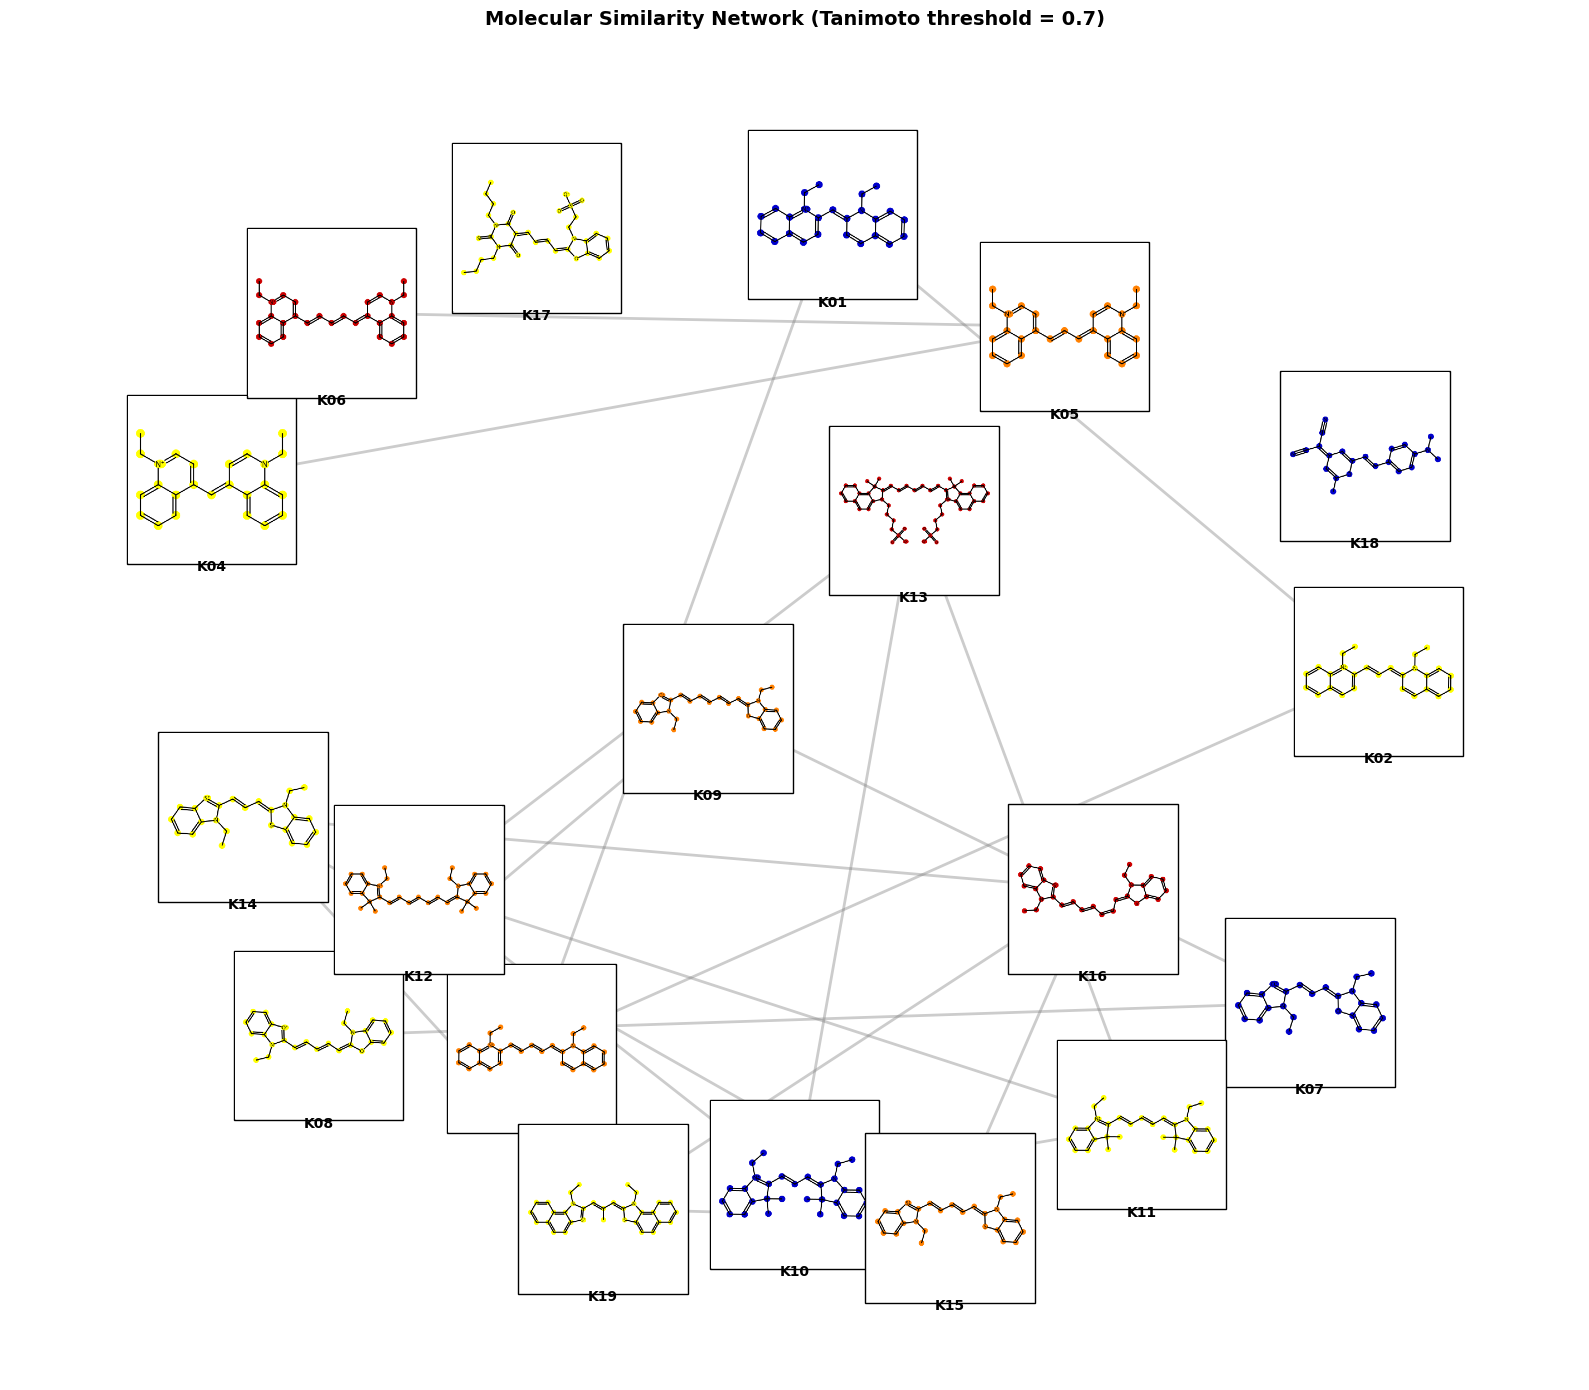

Network nodes: 19
Network edges: 21


In [78]:
import networkx as nx
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

# Create network with filtered similarities
threshold = 0.7
G = nx.Graph()

# Add nodes
for mol_id in d_nodes.keys():
    G.add_node(mol_id)

# Add edges
for (mol_id1, mol_id2), similarity in d_similarity.items():
    if similarity >= threshold:
        G.add_edge(mol_id1, mol_id2, weight=similarity)

# Create figure
fig, ax = plt.subplots(figsize=(16, 14))

# Get layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Draw edges first
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray', width=2, ax=ax)

# Function to get color based on absorption maximum
def get_color(abs_max):
    if abs_max is None:
        return (0.5, 0.5, 0.5)  # Gray
    elif abs_max > 750:
        return (0.8, 0, 0)  # Dark red
    elif abs_max > 650:
        return (1, 0.5, 0)  # Orange/yellow
    elif abs_max > 550:
        return (1, 1, 0)  # Yellow
    else:
        return (0, 0, 0.8)  # Blue

# Draw molecular structures as nodes
for node in G.nodes():
    mol = d_nodes[node]['mol']
    abs_max = d_nodes[node]['abs_max']
    # Get color
    rgb_color = get_color(abs_max)
    
    # Generate molecule image with highlighting
    img = Draw.MolToImage(mol, size=(300, 300), 
                          highlightAtoms=list(range(mol.GetNumAtoms())),
                          highlightColor=rgb_color)
    
    # Create offset image
    imagebox = OffsetImage(img, zoom=0.4)
    ab = AnnotationBbox(imagebox, pos[node], 
                        frameon=True, 
                        pad=0.1,
                        box_alignment=(0.5, 0.5))
    ax.add_artist(ab)
    
    # Add label below structure
    ax.text(pos[node][0], pos[node][1]-0.15, node, 
            ha='center', va='top', fontsize=10, fontweight='bold')

# Set axis limits with padding
x_values = [pos[node][0] for node in G.nodes()]
y_values = [pos[node][1] for node in G.nodes()]
margin = 0.3
ax.set_xlim(min(x_values)-margin, max(x_values)+margin)
ax.set_ylim(min(y_values)-margin, max(y_values)+margin)

ax.axis('off')
plt.title(f'Molecular Similarity Network (Tanimoto threshold = {threshold})', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"Network nodes: {G.number_of_nodes()}")
print(f"Network edges: {G.number_of_edges()}")

::::{tip} Task C4

Interprete the results: Do similar molecules absorb similarly? Is the recognized similarity and respective scoring meaningful? 

Submit your notebook/interpretation *via* StudOn (or E-Mail).

::::